# Analysis of GNIP dataset: 400k geolocations

In [2]:
import pandas as pd
import numpy as np
from datetime import date,timedelta
from tqdm import tqdm
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from scipy.spatial import cKDTree

def time_2_date(time_array):
    fechas=[];days=[];hours=[];years=[];months=[]
    for times in tqdm(time_array):
        tab_date=times.split('-')
        fecha=(date(int(tab_date[0]),int(tab_date[1]),int(tab_date[2][:2]))).weekday()
        hour=int(times.split('T')[1][:2])
        year=tab_date[0]
        month=tab_date[1]
        day=tab_date[2][:2]
        years.append(year)
        days.append(day)
        fechas.append(fecha)
        hours.append(hour)
        months.append(month)
    return days,fechas,hours,years,months

work_hours=range(8,20)
home_hours=list(set(range(24))-set(work_hours))
work_days=range(5)
home_days=list(set(range(7))-set(work_days))

dgeo_gnip=pd.read_csv(header=None,sep="\t",filepath_or_buffer="/datastore/complexnet/jlevyabi/geoloc/txt_files/precise_locs.txt")
dgeo_gnip.columns=["usr","time","lat","lon"]
fechas,days,hours,years,month=time_2_date(dgeo_gnip.time)
dgeo_gnip['day']=days;dgeo_gnip['hour']=hours;dgeo_gnip['year']=years;dgeo_gnip['month']=month;dgeo_gnip['fecha']=fechas
dgeo_gnip=dgeo_gnip.drop(labels="time",axis=1)

france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],[8.4375,51.2344073516],[-4.9658203125,51.2344073516],[-4.9658203125,42.3585439175]])
locs=[Point((lon,lat)) for lon,lat in zip(dgeo_gnip.lon,dgeo_gnip.lat)]

dgeo_france_gnip=dgeo_gnip[[france.contains(geo_pt) for geo_pt in locs]]
dgeo_work_gnip=dgeo_france_gnip[dgeo_france_gnip.day.isin(work_days) & dgeo_france_gnip.hour.isin(work_hours)]#.drop(["day","hour"],axis=1)
dgeo_home_gnip=dgeo_france_gnip[dgeo_france_gnip.day.isin(home_days) | dgeo_france_gnip.hour.isin(home_hours)]#.drop(["day","hour"],axis=1fecha


100%|██████████| 449975/449975 [00:05<00:00, 86954.26it/s]


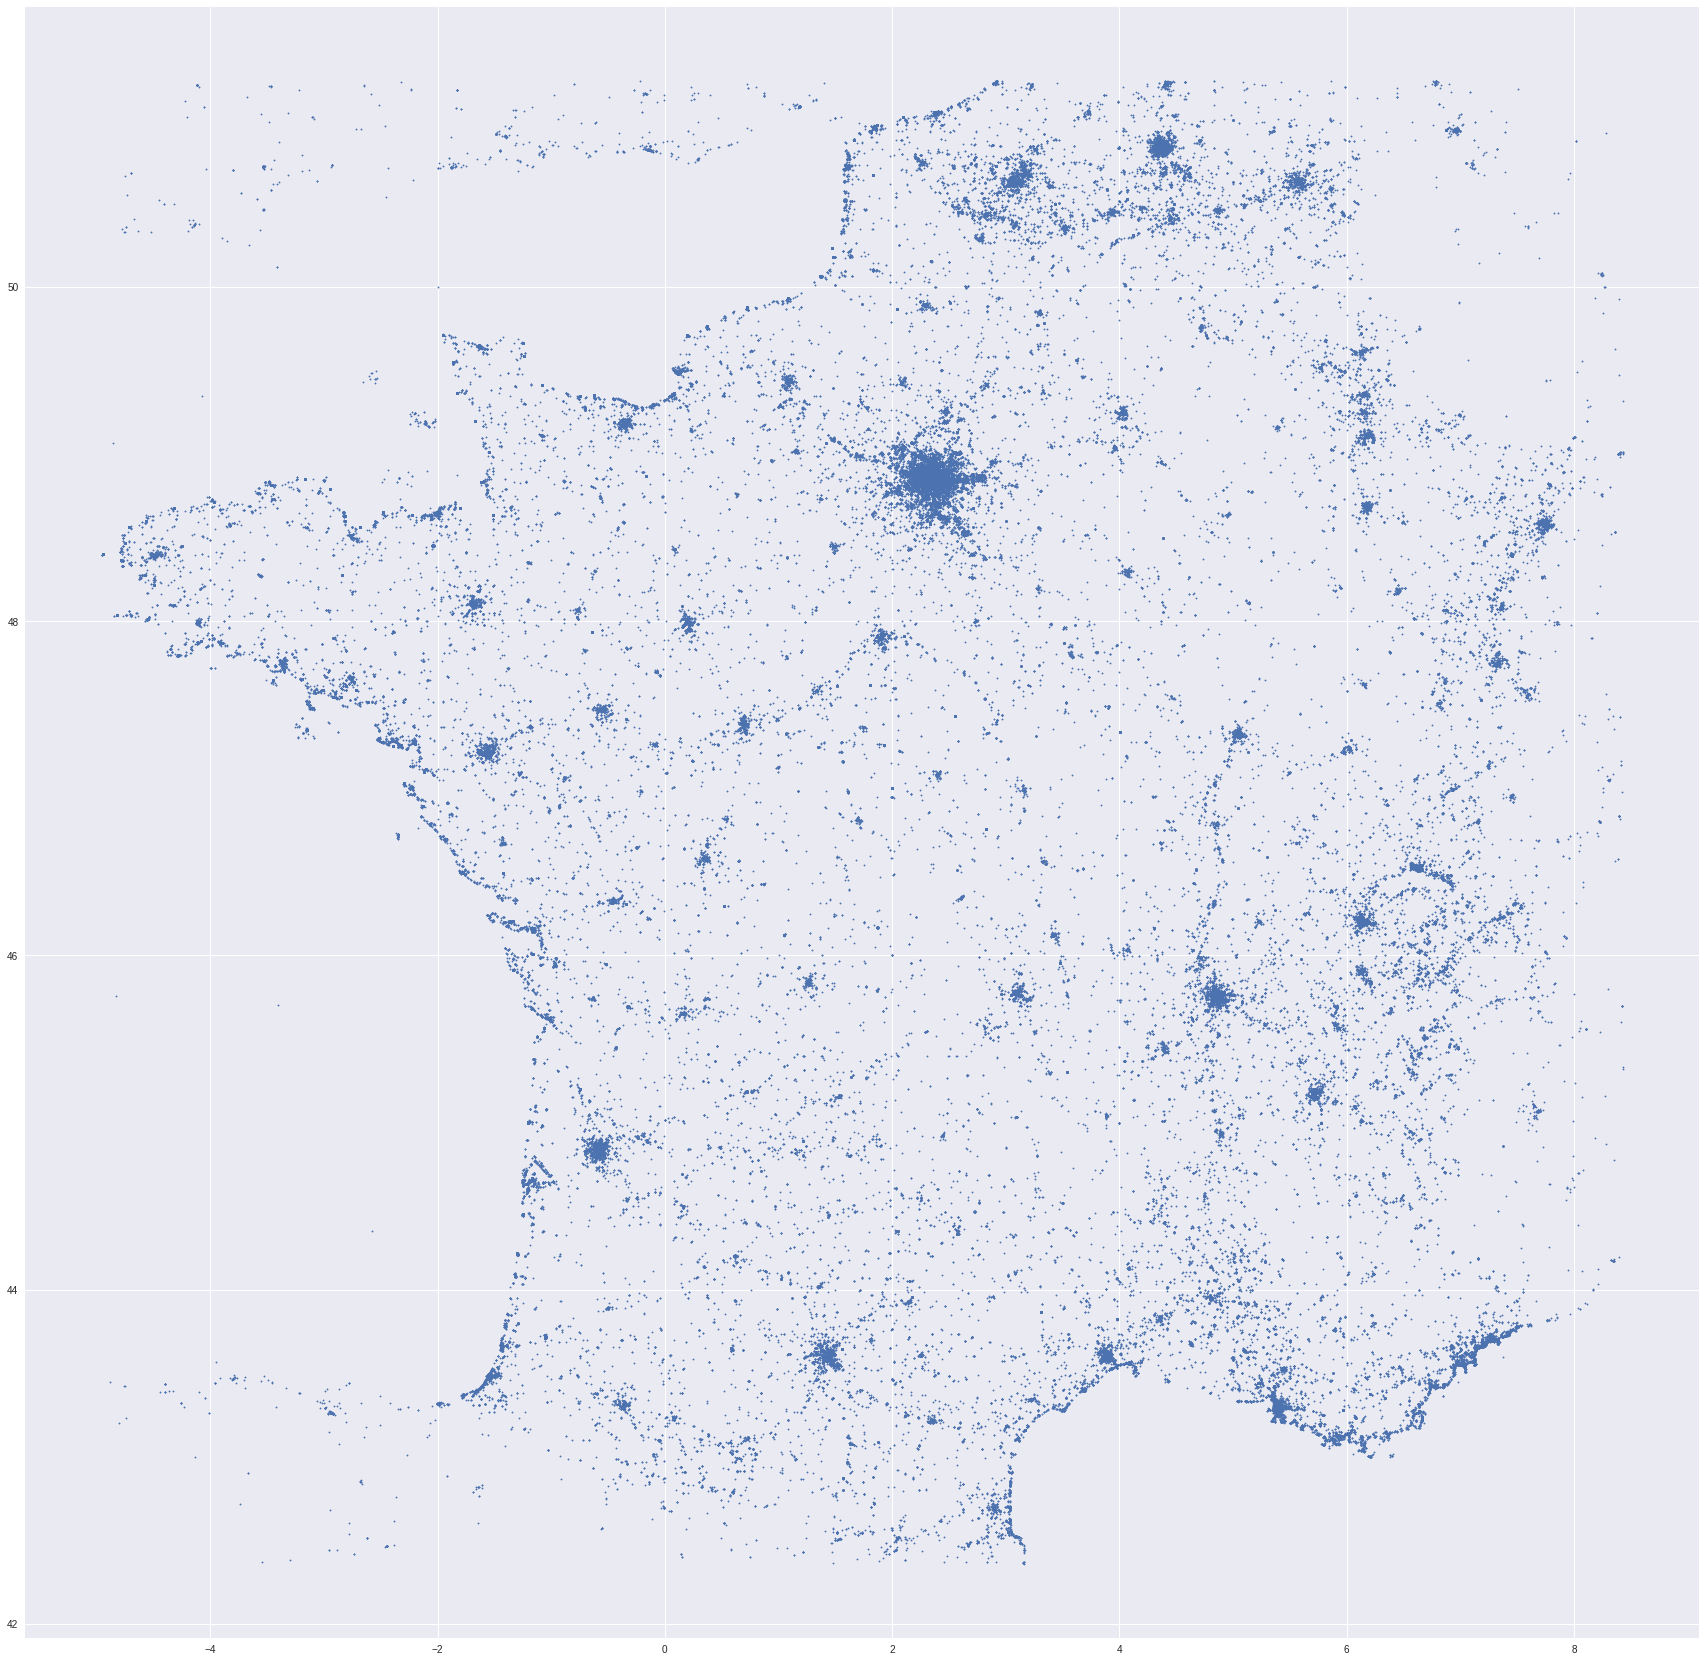

In [52]:
import seaborn as sns
sns.plt.figure(figsize=(30,30))
plt.scatter(dgeo_france_gnip.lon,dgeo_france_gnip.lat,s=2)
plt.show()

In [53]:
dgeo_france_gnip.head()

,usr,lat,lon,day,hour,year,month,fecha
2,2372261600,49.458619,1.066828,1,9,2016,02,02
3,2287344225,48.587497,7.752464,1,9,2016,02,02
4,2147956687,46.200825,6.130085,1,9,2016,02,02
5,527907525,43.659503,7.206446,1,9,2016,02,02
6,361861626,45.450600,6.978100,1,9,2016,02,02


In [ ]:
from collections import Counter
from geopy.distance import vincenty
from datetime import datetime
import time
import numpy as np
from pyproj import Proj, transform
from scipy.spatial import cKDTree
from scipy import sparse
import sqlite3 as lite
import sys
import os
path = "/datastore/complexnet/twitter/data/users.db"
con = lite.connect(path)



#http://epsg.io/27700-5339 (accuracy: 1.0m)
uk = '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 \
+x_0=400000 +y_0=-100000 +ellps=airy \
+towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs'
 

def proj_arr(points,proj_to):
    """Project geographic co-ordinates to get cartesian x,y. Transform(origin|destination|lon|lat)"""
    inproj = Proj(init='epsg:4326')
    outproj = Proj(proj_to)
    func = lambda x: transform(inproj,outproj,x[1],x[0])
    return np.array(list(map(func, points)))

def conv_to_hours(time_delt):
    return abs(time_delt.days)*24.0+time_delt.seconds//3600


def is_real(visit_df,max_km_var,max_km_per_h,min_loc=3):
    dists=[];N=visit_df.shape[0]
    if(N<=min_loc):
        return None,0,0,0
    points = np.array(visit_df)[:,:2].astype(float).tolist()
    proj_pnts = proj_arr(points, uk)
    tree = cKDTree(proj_pnts)
    cut_off_metres = max_km_var*(3e3) #90KM (our projection is in metres!)
    tree_dist = tree.sparse_distance_matrix(tree,cut_off_metres,p=2) 
    spa_dists = 0.001*sparse.tril(tree_dist, k=-1).todense()   # zero the main diagonal (distance=0)
    times = [datetime(val[2],val[3],val[4],val[1]) for val in np.array(visit_df)[:,2:].astype(int).tolist()]
    temp_dist=np.array([conv_to_hours(t1-t2) for t1 in times for t2 in times]).reshape((N,N))
    speed=spa_dists/temp_dist;speed=speed[np.isfinite(speed)]
    if len(speed)>1 and np.max(speed)>max_km_per_h:
        return False,0,med,speed
    rel_dist=spa_dists[np.tril_indices(N,k=-1)]
    med=np.mean(rel_dist)
    if med>max_km_var:
        return False,1,med,speed
    return True,"",rel_dist,speed

def filter_crazy_users(dic,max_km_var,max_km_per_h):
    dic_too_fast={}
    dic_too_var={}
    dic_mar={}
    dic_dist={};dic_speed={}
    dic_real_usrs={}
    with con:
        for usr,visits in tqdm(dic.items()):
            cur = con.cursor()
            cur.execute("SELECT screen_name FROM users WHERE id = '%s'" %usr )
            s_name=cur.fetchone()
            if (s_name!=None and "maree_info" in s_name[0]):
                dic_mar[usr]=visits
                continue
            visits_info=pd.DataFrame(data=visits,columns=["lat","lon","day","hour","year","month","fecha"])
            if len(visits_info.lat)>20 and len(Counter([tuple(x)
                                                         for x in visits_info[["lat","lon"]].values.tolist()]))==1:
                dic_mar[usr]=visits
            ticket,code,dists,speed=is_real(visits_info,max_km_var,max_km_per_h)
            if ticket==None:
                continue
            elif ticket:
                dic_dist[usr]=[np.mean(dists),np.max(dists),visits_info.shape[0]]
                dic_speed[usr]=[np.mean(speed)]
                dic_real_usrs[usr]=visits
            elif code==0:
                dic_dist[usr]=[np.mean(dists),np.max(dists),visits_info.shape[0]]
                dic_speed[usr]=[np.mean(speed)]
                dic_too_fast[usr]=visits
            else:
                dic_dist[usr]=[np.mean(dists),np.max(dists),visits_info.shape[0]]
                dic_too_var[usr]=visits
    return dic_real_usrs,dic_too_fast,dic_too_var,dic_mar,dic_dist,dic_speed

def fact_geo_frame_by_usr(d_home,prec=3):
    dic_locs={}
    for index,row in tqdm(d_home.iterrows()):
        usr,lat,lon,day,hour,year,month,fecha=(row.usr,round(row.lat,prec),round(row.lon,prec),
                                               row.day,row.hour,row.year,row.month,row.fecha)
        if usr not in dic_locs:dic_locs[usr]=[(lat,lon,day,hour,year,month,fecha)]
        else:dic_locs[usr].append((lat,lon,day,hour,year,month,fecha))
    return dic_locs

def fast_get_repr_location(dic_locs,max_km_var=10,max_km_per_h=900):
    d_real,d_fast,d_vars,dic_mar,dic_dist,dic_speed=filter_crazy_users(dic_locs,max_km_var,max_km_per_h)
    res=[]
    for usr,visits in tqdm(d_real.items()):
        visit_usrs=Counter(visits)
        most_freq=visit_usrs.most_common(1)[0]
        res.append((usr,most_freq[0][0],most_freq[0][1],most_freq[1],sum(visit_usrs.values()),
                    (most_freq[1]+0.0)/sum(visit_usrs.values())))
    return(d_real,d_fast,d_vars,dic_mar,dic_dist,dic_speed,pd.DataFrame(data=res,columns=["usr","lat","lon","nb_loc","total_geo","proba"]))

dic_locs_home=fact_geo_frame_by_usr(dgeo_home)
dic_locs_reals_home,d_locs_fast_home,d_locs_vars_home,dic_mar_home,dic_dist_home,dic_speed_home,pre_home=fast_get_repr_location(dic_locs_home,max_km_var=10)
dic_locs_all=fact_geo_frame_by_usr(dgeo_france)
dic_locs_reals_all,d_locs_fast_all,d_locs_vars_all,dic_mar_all,dic_dist_all,dic_speed_all,pre_all=fast_get_repr_location(dic_locs_all,max_km_var=10)



#pre_home.to_csv('/datastore/complexnet/jlevyabi/ml_soc_econ/data_files/
#UKSOC_rep/dgeo_home_most_freq.csv',header=True,index=None,sep=',')

190155it [02:21, 1345.32it/s]
  0%|          | 0/31820 [00:00<?, ?it/s]/home/jlevyabi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/jlevyabi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in true_divide
  0%|          | 65/31820 [00:03<36:05, 14.66it/s]/home/jlevyabi/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:549: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/jlevyabi/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
100%|██████████| 6231/6231 [00:00<00:00, 15939.82it/s]
358783it [03:57, 1509.24it/s]
100%|██████████| 11323/11323 [00:00<00:00, 11900.06it/s]


In [8]:
import pickle 
d_mobility_analysis_home={'dic_locs_reals_home':dic_locs_reals_home,'d_locs_fast_home':d_locs_fast_home,
                     'd_locs_vars_home':d_locs_vars_home,'dic_mar_home':dic_mar_home,
                    'dic_dist_home':dic_dist_home,'dic_speed_home':dic_speed_home,'pre_home':pre_home,
                         'dic_locs_home':dic_locs_home}

d_mobility_analysis_all={'dic_locs_reals_all':dic_locs_reals_all,'d_locs_fast_all':d_locs_fast_all,
                     'd_locs_vars_all':d_locs_vars_all,'dic_mar_home':dic_mar_all,
                    'dic_dist_all':dic_dist_all,'dic_speed_all':dic_speed_all,'pre_all':pre_all,
                         'dic_locs_all':dic_locs_all}

In [ ]:
d_mobility_analysis_home=pickle.load(open('d_mobility_analysis_home.p','rb'))
d_mobility_analysis_all=pickle.load(open('d_mobility_analysis_all.p','rb'))